## Preparing to work

In [17]:
import tweepy
from textblob import TextBlob as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import folium
from folium import plugins
from wordcloud import WordCloud, STOPWORDS

In [18]:
# use your credentials of twitter developer
consumer_key = "     "
consumer_secret = "     "
access_token = "    "
access_token_secret = "     "

In [19]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
token = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True,retry_count=5)

In [20]:
tweets =[]
info = []
polarities = []
aux = []

keywords = ("Bolsonaro OR Brazilian President OR Brazil's President OR President of Brazil")

In [ ]:
while len(info) < 2000:
    for tweet in tweepy.Cursor(token.search,q=keywords, tweet_mode='extended',
                              rpp=2000, result_type="mixed",lang="en",
                              include_entities=True).items(2000):
        if tweet.full_text not in info:
            if 'retweeted_status' in dir(tweet):
                aux=tweet.retweeted_status.full_text
            else:
                aux=tweet.full_text
                
            newtweet = aux.replace("\n", " ")
          
            tweets.append(newtweet)
            info.append(tweet)

In [ ]:
tweets_df = pd.DataFrame(tweets, columns = ['Tweets'])
tweets_df['len']  = np.array([len(tweet) for tweet in tweets])
tweets_df['ID']   = np.array([tweet.id for tweet in info])
tweets_df['USER']   = np.array([tweet.user.screen_name for tweet in info])
tweets_df['userName'] = np.array([tweet.user.name for tweet in info])
tweets_df['User Location']    = np.array([tweet.user.location for tweet in info])
tweets_df['Language'] = np.array([tweet.user.lang for tweet in info])
tweets_df['Date'] = np.array([tweet.created_at for tweet in info])
tweets_df['Source'] = np.array([tweet.source for tweet in info])
tweets_df['Likes']  = np.array([tweet.favorite_count for tweet in info])
tweets_df['Retweets']    = np.array([tweet.retweet_count for tweet in info])
tweets_df['Geo']    = np.array([tweet.geo for tweet in info])
tweets_df['Coordinates']    = np.array([tweet.coordinates for tweet in info])         
tweets_df['Place']    = np.array([tweet.place for tweet in info])

tweets_df.to_csv("tweets_about_president_Bolsonaro.csv")

In [ ]:
from google.colab import files
files.download("tweets_about_president_Bolsonaro.csv")

In [ ]:
tweets_df = pd.read_csv("tweets_about_president_Bolsonaro.csv")

## Sentimental Analysis

In [ ]:
analysis = None

for tweet in tweets_df['Tweets']:
    analysis = tb(tweet)
    polarity = analysis.sentiment.polarity
    polarities.append(polarity)




positive = 0
neutral = 0
negative = 0

for polarity in polarities:
    if polarity > 0:
        positive += 1
        
    elif polarity < 0:
        negative += 1
        
    else:
        neutral += 1

In [ ]:
print('Positive tweets: ',positive)
print('Neutral tweets: ',neutral)
print('Negative tweets: ', negative)

In [ ]:
#calcula percentual
pos_pct=positive*100/len(polarities)
neg_pct=negative*100/len(polarities)
neu_pct=neutral*100/len(polarities)

In [ ]:
sentiments = ['Positivos', 'Negativos','Neutros']
percents = [pos_pct, neg_pct, neu_pct]

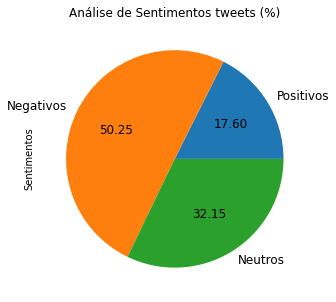

In [13]:
pie_chart = pd.Series(percents, index=sentiments,name='Sentimentos')
pie_chart.plot.pie(fontsize=12, autopct='%.2f', figsize=(5, 5),title="Análise de Sentimentos tweets (%)");

Text(0, 0.5, 'Total de tweets')

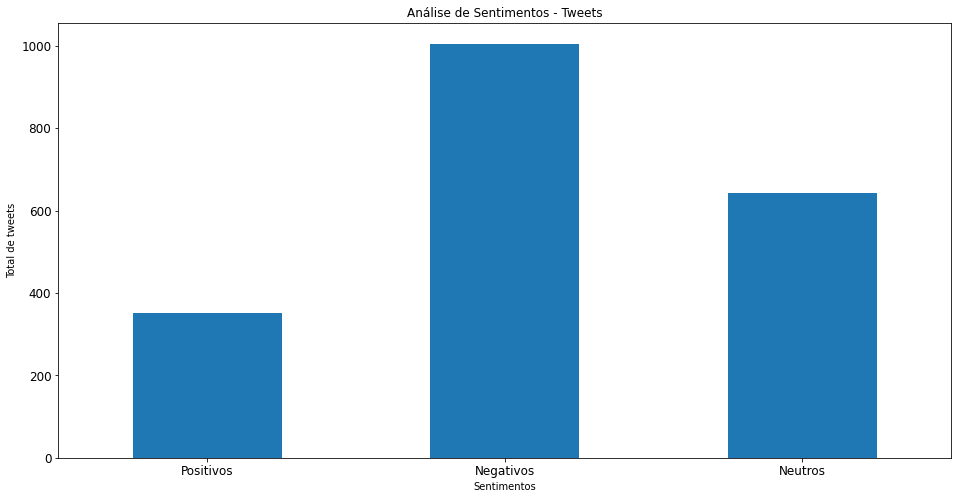

In [15]:
bar_chart = pd.DataFrame({'Sentimentos':sentiments, 'val':[positive,negative,neutral]})
bar_chart.plot(kind = 'bar',x = 'Sentimentos',legend=False, title = "Análise de Sentimentos - Tweets", figsize = (16,8), fontsize = 12)


plt.xticks(rotation = 0)
plt.xlabel("Sentimentos")
plt.ylabel("Total de tweets")

## Heat Map

In [ ]:
tweets_df['Polarity'] = polarities # inserting polarity to Dataframe

In [ ]:
# Separating tweets into two categories
positive_tweets = tweets_df['Polarity'] > 0
negative_tweets = tweets_df['Polarity'] < 0

In [ ]:
geolocator = Nominatim(user_agent="TweeterSentiments")

latitude_positive = []
longitude_positive = []
latitude_negative = []
longitude_negative = []

for user_location in tweets_df[positive_tweets]['User Location']:
    try:
        location = geolocator.geocode(user_location)
        latitude_positive.append(location.latitude)
        longitude_positive.append(location.longitude)
    except:
        continue
        
for user_location in tweets_df[negative_tweets]['User Location']:
    try:
        location = geolocator.geocode(user_location)
        latitude_negative.append(location.latitude)
        longitude_negative.append(location.longitude)
    except:
        continue

In [ ]:
# map of positive tweets
coordenadas = np.column_stack((latitude_positive, longitude_positive))

mapa = folium.Map(zoom_start=3.)
mapa.add_child(plugins.HeatMap(coordenadas))
mapa.save('positive_tweets.html')
mapa

In [ ]:
# map of negative tweets
coordenadas = np.column_stack((latitude_negative, longitude_negative))

mapa = folium.Map(zoom_start=3.)
mapa.add_child(plugins.HeatMap(coordenadas))
mapa.save('negative_tweets.html')
mapa

## Word Cloud

In [ ]:
words = ' '.join(tweets_df[positive_tweets]['Tweets'])

words_clean = " ".join([word for word in words.split()
                            if 'https' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [ ]:
keywords = keywords.split("")
keywords

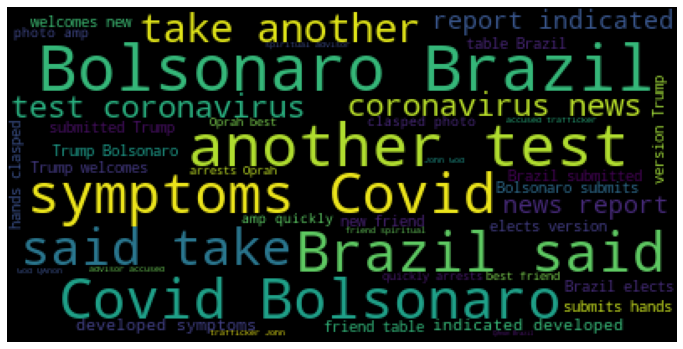

In [ ]:
# positive tweets
stopwords = set(STOPWORDS)
# excluding words used in the search, from the word cloud
for word in keywords:
    stopwords.add(word)
    stopwords.add("President")
    stopwords.add("Jair")

wc = WordCloud(background_color='black', #cor de fundo
               mode="RGB",
               stopwords = stopwords,
               normalize_plurals= True).generate(words_clean)

fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(wc, interpolation='bilinear')
ax.set_axis_off()
 
plt.imshow(wc);

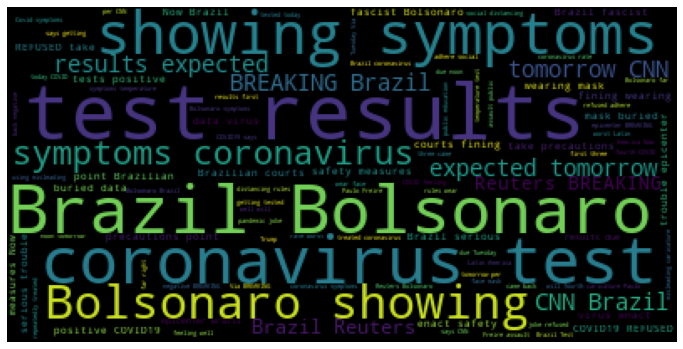

In [ ]:
# negative Tweets

words = ' '.join(tweets_df[negative_tweets]['Tweets'])

words_clean = " ".join([word for word in words.split()
                            if 'https' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wc = WordCloud(background_color='black', #cor de fundo
               mode="RGB",
               stopwords = stopwords,
               normalize_plurals= True).generate(words_clean)

fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(wc, interpolation='bilinear')
ax.set_axis_off()
plt.savefig('negative_tweets.png', dpi=300)
plt.imshow(wc);

In [ ]:
files.download('negative_tweets.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>